I've made this notebook to demonstrate my solution, you can read detailed explanation [here](https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/279170). It doesn't include full CV and inference, instead I tried to make it short and include only key elements: preprocessing and NN architecture. I did a lot of refactoring to simplify my code and to fit kaggle RAM limitations, it might affect performance a bit, but hopefully not so much.

One thing that I changed is data preprocessing using xarray instead of pandas - I really liked how well it fit multidimensional nature of the data. It speed up many group by operations by replacing them with aggregations over array dimensions.

Here I also include 2 modes of training: *single-stock* and *multi-stock*. *multi-stock* training works really fast and you can get decent results after 20 minutes. In this mode train batch includes targets for all stocks in time_id and you have only 3830 training samples. In *single-stock* mode input is still the same and includes data from all stocks, but it also has single stock_id as input and only single stock target for it is predicted. This way batch contains much more diverse (stock_id, time_id) pairs, and I believe this diversity is important to get better score. During the competition I used *single-stock* training, despite much longer training times. Usually my public score was better than my validation score by 0.005-0.006. My best single models without using nearest neigbours scored ~0.199-0.200 on public while validation score was ~0.206. In *multi-stock* mode I can achieve currently only ~0.210-0.211 score, though I haven't tried to wait until training end in *single-stock* mode after refactoring, but it should be better.

Anyway this just a baseline, and there are a lot of things to experiment with: stock attention placement (before/after RNN and internal implementation, feature normalization (you should probably do something with volumes as the way I did it didn't work well on private test), network dimensions, batch size, lr, etc.

In [1]:
%%capture
!pip install einops
!pip install lightning --quiet

In [2]:
import gc
import einops
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from joblib import Parallel, delayed

import torch
from torch import nn
import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch import Trainer
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/RBS DL 2025/PRO/data'

Mounted at /content/drive


In [4]:
n_features = 21
n_stocks = 112
n_seconds = 600
# if coarsen > 1, data will be aggregated per this number of seconds. used to reduce mem usage
coarsen = 3

In [5]:
# used later for plotting historical train/val results
class MetricHistory(Callback):
    def __init__(self):
        super().__init__()
        self.train_vol = []
        self.valid_vol = []

    def on_train_epoch_end(self, trainer, pl_module):
        m = trainer.callback_metrics
        self.train_vol.append(m['train/vol_loss'].cpu().item())
        self.valid_vol.append(m['valid/vol_loss'].cpu().item())

In [6]:
def prepare_data(stock_id, stock_ind, set, time_ids, coarsen, norm, out):
    #load book data
    df_book = pd.read_parquet(f'{data_dir}/book_{set}.parquet/stock_id={stock_id}')
    df_min_second = df_book.groupby('time_id').agg(min_second=('seconds_in_bucket', 'min'))
    df_book = df_book.merge(df_min_second, left_on='time_id', right_index=True) \
        .eval('seconds_in_bucket = seconds_in_bucket - min_second') \
        .drop('min_second', axis=1)
    # load trade data
    df_trade = pd.read_parquet(f'{data_dir}/trade_{set}.parquet/stock_id={stock_id}') \
        .merge(df_min_second, left_on='time_id', right_index=True) \
        .eval('seconds_in_bucket = seconds_in_bucket - min_second') \
        .drop('min_second', axis=1)
    # merge book + trade
    df = pd.merge(df_book, df_trade, on=['time_id', 'seconds_in_bucket'], how='outer')
    df['stock_id'] = stock_id
    # set multi index
    df = df.set_index(['stock_id', 'time_id', 'seconds_in_bucket'])
    # pandas -> xarray
    df = df.to_xarray().astype('float32')
    # processing seconds col to make sure it works fine
    df = df.reindex({'time_id': time_ids, 'seconds_in_bucket': np.arange(n_seconds)})
    # forward fill imputation: if no new quote, old quote stays active
    for name in ['bid_price1', 'bid_price2', 'ask_price1', 'ask_price2',
         'bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']:
        df[name] = df[name].ffill('seconds_in_bucket')
    # wap1/2
    df['wap1'] = (df.bid_price1 * df.ask_size1 + df.ask_price1 * df.bid_size1) / (df.bid_size1 + df.ask_size1)
    df['wap2'] = (df.bid_price2 * df.ask_size2 + df.ask_price2 * df.bid_size2) / (df.bid_size2 + df.ask_size2)
    # log(wap1/2)
    df['log_return1'] = np.log(df.wap1).diff('seconds_in_bucket')
    df['log_return2'] = np.log(df.wap2).diff('seconds_in_bucket')
    df['current_vol'] = (df.log_return1 ** 2).sum('seconds_in_bucket') ** 0.5
    df['current_vol_2nd_half'] = (df.log_return1[..., 300:] ** 2).sum('seconds_in_bucket') ** 0.5
    # downsmapling if coursen > 1
    if coarsen > 1:
        mean_features = ['ask_price1', 'ask_price2', 'bid_price1', 'bid_price2',  'ask_size1', 'ask_size2',
               'bid_size1', 'bid_size2', 'price']
        sum_features = ['size', 'order_count']

        df = xr.merge((df[mean_features].coarsen({'seconds_in_bucket': coarsen}, coord_func='min').mean(),
                       df[sum_features].coarsen({'seconds_in_bucket': coarsen}, coord_func='min').sum(),
                       df[['current_vol', 'current_vol_2nd_half']]))
        df['wap1'] = (df.bid_price1 * df.ask_size1 + df.ask_price1 * df.bid_size1) / (df.bid_size1 + df.ask_size1)
        df['wap2'] = (df.bid_price2 * df.ask_size2 + df.ask_price2 * df.bid_size2) / (df.bid_size2 + df.ask_size2)
        df['log_return1'] = np.log(df.wap1).diff('seconds_in_bucket')
        df['log_return2'] = np.log(df.wap2).diff('seconds_in_bucket')
    # ba spread
    df['spread1'] = df.ask_price1 - df.bid_price1
    # order book slope
    df['spread2'] = df.ask_price2 - df.ask_price1
    df['spread3'] = df.bid_price1 - df.bid_price2
    df['total_volume'] = df.ask_size1 + df.ask_size2 + df.bid_size1 + df.bid_size2
    df['volume_imbalance1'] = df.ask_size1 + df.ask_size2 - df.bid_size1 - df.bid_size2
    df['volume_imbalance2'] = (df.ask_size1 + df.ask_size2 - df.bid_size1 - df.bid_size2) / df.total_volume
    for name in ['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2', 'size', 'order_count', 'total_volume']:
        df[name] = np.log1p(df[name])
        # df[name] = df[name].rank('seconds_in_bucket')
    df['volume_imbalance1'] = np.sign(df['volume_imbalance1']) * np.log1p(abs(df['volume_imbalance1']))

    df = df.fillna({'ask_price1': 1, 'ask_price2': 1, 'bid_price1': 1, 'bid_price2': 1,  'ask_size1': 0, 'ask_size2': 0,
               'bid_size1': 0, 'bid_size2': 0, 'price': 1, 'size': 0, 'order_count': 0, 'wap1': 1, 'wap2': 1,
               'log_return1': 0, 'log_return2': 0, 'spread1': 0, 'spread2': 0, 'spread3': 0, 'total_volume': 0,
               'volume_imbalance1': 0, 'volume_imbalance2': 0, 'current_vol': 0, 'current_vol_2nd_half': 0})
    features = ['ask_price1', 'ask_price2', 'bid_price1', 'bid_price2',  'ask_size1', 'ask_size2',
               'bid_size1', 'bid_size2', 'price', 'size', 'order_count', 'wap1', 'wap2',
               'log_return1', 'log_return2', 'spread1', 'spread2', 'spread3', 'total_volume',
               'volume_imbalance1', 'volume_imbalance2']
    extra = ['current_vol', 'current_vol_2nd_half']

    if norm is not None:
        mean = norm['mean'].sel(stock_id=stock_id)
        std = norm['std'].sel(stock_id=stock_id)
    else:
        mean = df.mean(('time_id', 'seconds_in_bucket')).drop(['current_vol', 'current_vol_2nd_half'])
        std = df.std(('time_id', 'seconds_in_bucket')).drop(['current_vol', 'current_vol_2nd_half'])

    df.update((df - mean) / std)
    df = df.astype('float32')

    out[:, stock_ind] = einops.rearrange(df[features].to_array().values, 'f () t sec -> t sec f')
    return df[extra], {'mean': mean, 'std': std}

In [7]:
# pytorch dataset: feeds data into model while training
class OptiverDataset(Dataset):
    def __init__(self, features_data, extra_data, mode, time_ids):
        self.features_data = features_data
        # targets and current_vol
        self.extra_data = extra_data
        self.time_ids = time_ids
        self.mode = mode

    # tells the number of samples to pytorch
    def __len__(self):
        if self.mode == 'single-stock':
            return len(self.time_ids) * n_stocks
        elif self.mode == 'multi-stock':
            return len(self.time_ids)

    # for a given index i, return the corresponding input features + labels for model training.
    def __getitem__(self, i):
        if self.mode == 'single-stock':
            time_id = self.time_ids[i // n_stocks]
            time_ind = self.extra_data.indexes['time_id'].get_loc(time_id)
            stock_ind = i % n_stocks
            stock_id = self.extra_data.indexes['stock_id'][stock_ind]
            return {
                'data': self.features_data[time_ind], # (112, 600, 21)
                'target': self.extra_data['target'].values[time_ind, stock_ind],  # (1,)
                'current_vol': self.extra_data['current_vol'].values[time_ind, stock_ind],  # (1,)
                'current_vol_2nd_half': self.extra_data['current_vol_2nd_half'].values[time_ind, stock_ind],  # (1,)
                'time_id': time_id,
                'stock_id': stock_id,
                'stock_ind': stock_ind
            }
        elif self.mode == 'multi-stock':
            time_id = self.time_ids[i]
            time_ind = self.extra_data.indexes['time_id'].get_loc(time_id)
            return {
                'data': self.features_data[time_ind], # (112, 600, 21)
                'target': self.extra_data['target'].values[time_ind],  # (112,)
                'current_vol': self.extra_data['current_vol'].values[time_ind],  # (112,)
                'current_vol_2nd_half': self.extra_data['current_vol_2nd_half'].values[time_ind],  # (112,)
                'time_id': time_id,
            }

Time Attention Intuition:

Maybe volatility spikes at the beginning of a window. Or maybe at the end of a window. Fixed pooling (mean, max) can't adapt to this. This TimeAttention layer learns to adapt dynamically based on data patterns.

In [8]:
# not all seconds are equally informative — attention helps model prioritize
class TimeAttention(nn.Module):
    # learn which parts of the time window are important
    def __init__(self, steps):
        super().__init__()
        self.steps = steps
        self.weights = nn.Parameter(torch.zeros(steps))

    # the forward pass - collpases time dimension in a weighted manner
    def forward(self, x):
        # x: (b, st, t, f)
        attn = F.softmax(self.weights, 0)
        x = torch.einsum('b s t f, t -> b s f', x, attn)
        return x

Stock Attention Intuition:
Each stock might borrow information from other correlated stocks.

Example:

If stock_10 and stock_25 usually move together, attention will learn to pull information between them. Helps the model generalize better, especially when market events affect multiple stocks.

In [9]:
# You can experiment with other ideas for stock attention: maybe it could be
# something like MultiHeadAttention module with keys and queries that depends on current input,
# maybe it could be a linear combination of all stocks (full connected layer),maybe you can try sparse softmax

class StockAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((n_stocks, n_stocks)))
        self.bias = nn.Parameter(torch.zeros(n_stocks))
        self.fc_combine = nn.Linear(dim * 2, dim)

    def forward(self, x):
        # x: (batch, stock, time, feature)
        # compute attention scores across assets
        attn = F.softmax(self.weight + self.bias[None, :], dim = -1) # (st, st)
        y = torch.einsum('b i ..., j i -> b j ...', x, attn)
        x = torch.cat((x, y), -1)
        x = self.fc_combine(x)
        return x

In [10]:
class OptiverModel(pl.LightningModule):
    def __init__(self, mode='multi-stock', dim=32, conv1_kernel=3, rnn_layers=2, rnn_dropout=0.3,
                 n_features=21, aux_loss_weight=1.0):
        super().__init__()
        self.save_hyperparameters()
        # stpck specific embeddings
        self.stock_emb = nn.Embedding(n_stocks, dim)
        self.stock_emb.weight.data.normal_(0, 0.2)
        # 1D convolution across time for feature extraction
        self.conv1 = nn.Conv1d(n_features, dim, conv1_kernel, conv1_kernel)
        self.conv2 = nn.Conv1d(dim, dim, 1, 1)
        # Normalize features to stabilize training
        self.norm1 = nn.LayerNorm([n_stocks, dim])
        self.norm2 = nn.LayerNorm([n_stocks, dim])
        self.rnn = nn.GRU(dim, dim, rnn_layers, batch_first=True, dropout=rnn_dropout)
        # attention over time dimension
        self.timesteps_attn = TimeAttention(600 // conv1_kernel // coarsen) # full window
        self.timesteps_attn2 = TimeAttention(300 // conv1_kernel // coarsen) # half window
        # attention over stock
        self.stock_attn = StockAttention(dim)
        # final prediction heads
        self.fc_out1 = nn.Linear(dim, 1)
        self.fc_out2 = nn.Linear(dim, 1)
        # store perfromance over epochs
        self.history = pd.DataFrame()

    def forward(self, x, stock_ind=None):
        # x: (b, st, t, f)
        x = einops.rearrange(x, 'b st t f -> (b st) f t')
        x = self.conv1(x)
        x = einops.rearrange(x, '(b st) f t -> b t st f', st=n_stocks)
        x = F.gelu(x)
        x = self.norm1(x)
        x = einops.rearrange(x, 'b t st f -> (b st) f t')
        x = self.conv2(x)
        x = einops.rearrange(x, '(b st) f t -> b t st f', st=n_stocks)
        x = F.gelu(x)
        x = self.norm2(x)
        x = einops.rearrange(x, 'b t st f -> b st t f')
        x = self.stock_attn(x)
        x = x + self.stock_emb.weight[None, :, None, :]
        if self.hparams.mode == 'single-stock':
            x = x[torch.arange(len(x)), stock_ind][:, None]
        x = einops.rearrange(x, 'b st t f -> (b st) t f')
        x = self.rnn(x)[0]
        x = einops.rearrange(x, '(b st) t f -> b st t f', st=n_stocks if self.hparams.mode == 'multi-stock' else 1)
        x1 = self.timesteps_attn(x)
        x2 = self.timesteps_attn2(x[:, :, :self.timesteps_attn2.steps, :])
        x1 = self.fc_out1(x1)
        x2 = self.fc_out2(x2)
        x1 = x1 * 0.63393 - 5.762331
        x2 = x2 * 0.67473418 - 6.098946
        x1 = torch.exp(x1)
        x2 = torch.exp(x2)
        if self.hparams.mode == 'single-stock':
            return {
                'vol': x1[:, 0, 0], # (b,)
                'vol2': x2[:, 0, 0] # (b,)
            }
        else:
            return {
                'vol': x1[..., 0], # (b, st)
                'vol2': x2[..., 0] # (b, st)
            }

    def training_step(self, batch, batch_ind):
        out = self.common_step(batch, 'train')
        return out

    def validation_step(self, batch, batch_ind):
        return self.common_step(batch, 'valid')

    def common_step(self, batch, stage):
        out = self(batch['data'], batch['stock_ind'] if self.hparams.mode == 'single-stock' else None)
        mask1 = ~torch.isnan(batch['target'])
        target1 = torch.where(mask1, batch['target'], torch.tensor(1.0, device=self.device))
        mask2 = batch['current_vol_2nd_half'] > 0
        target2 = torch.where(mask2, batch['current_vol_2nd_half'], torch.tensor(1.0, device=self.device))
        vol_loss = (((out['vol'] - target1) / target1) ** 2)[mask1].mean() ** 0.5
        vol2_loss = (((out['vol2'] - target2) / target2) ** 2)[mask2].mean() ** 0.5
        loss = vol_loss + self.hparams.aux_loss_weight * vol2_loss
        self.log(f'{stage}/loss', loss.item(), on_step=False, on_epoch=True)
        self.log(f'{stage}/vol_loss', vol_loss.item(), on_step=False, on_epoch=True)
        self.log(f'{stage}/vol2_loss', vol2_loss.item(), on_step=False, on_epoch=True)
        return {
            'loss': loss,
            'target': batch['target'],
            'vol': out['vol'].detach(),
            'time_id': batch['time_id']
        }

    def common_epoch_end(self, outs, stage):
        target = torch.cat([x['target'] for x in outs])
        vol = torch.cat([x['vol'] for x in outs])
        time_ids = torch.cat([x['time_id'] for x in outs])
        mask = ~torch.isnan(target)
        target = torch.where(mask, target, torch.tensor(1.0, device=self.device))
        rmspe = (((vol - target) / target) ** 2)[mask].mean() ** 0.5
        self.log(f'{stage}/rmspe', rmspe, prog_bar=True, on_step=False, on_epoch=True)
        self.history.loc[self.trainer.current_epoch, f'{stage}/rmspe'] = rmspe.item()

    # def on_train_epoch_end(self, outputs):
    #     self.common_epoch_end(outputs, 'train')
    #     self.history_widget.clear_output(wait=True)
    #     with self.history_widget:
    #         ylim = [self.history.min().min(), self.history.quantile(0.95).max()]
    #         ylim[0] -= (ylim[1] - ylim[0]) * 0.05
    #         self.history.plot(color=['C1', 'C0'], style=['--', '-'], ylim=ylim)
    #         plt.show()

    # def on_validation_epoch_end(self, outputs):
    #     self.common_epoch_end(outputs, 'valid')

    # def on_train_epoch_end(self):
    #     outs = self.trainer.fit_loop.epoch_loop._outputs
    #     self.common_epoch_end(outs, 'train')
    #     self.history_widget.clear_output(wait=True)
    #     with self.history_widget:
    #         ylim = [self.history.min().min(), self.history.quantile(0.95).max()]
    #         ylim[0] -= (ylim[1] - ylim[0]) * 0.05
    #         self.history.plot(color=['C1', 'C0'], style=['--', '-'], ylim=ylim)
    #         plt.show()

    # def on_validation_epoch_end(self):
    #     outs = self.trainer.fit_loop.epoch_loop._outputs
    #     self.common_epoch_end(outs, 'valid')

    def on_fit_start(self):
        self.history_widget = widgets.Output()
        display(self.history_widget)

    def configure_optimizers(self):
        opt = Adam(self.parameters(), lr=0.001)
        # opt = Adam(self.parameters(), lr=0.0005) # single-stock
        sched = {
            'scheduler': ExponentialLR(opt, 0.93),
        # 'scheduler': ExponentialLR(opt, 0.9), #  single-stock
            'interval': 'epoch'
        }
        return [opt], [sched]

In [11]:
df_train = pd.read_csv(f'{data_dir}/train.csv')
train_data = np.memmap('/content/drive/MyDrive/Colab Notebooks/RBS DL 2025/PRO/train.npy', 'float16', 'w+',
                       shape=(df_train.time_id.nunique(), n_stocks, n_seconds // coarsen, n_features))

res = Parallel(n_jobs=4, verbose=51)(
    delayed(prepare_data)(stock_id, stock_ind, 'train', df_train.time_id.unique(), coarsen, None, train_data)
    for stock_ind, stock_id in enumerate(df_train.stock_id.unique())
)

train_extra = xr.concat([x[0] for x in res], 'stock_id')
train_extra['target'] = df_train.set_index(['time_id', 'stock_id']).to_xarray()['target'].astype('float32')
train_extra = train_extra.transpose('time_id', 'stock_id')
train_norm = {
    'mean': xr.concat([x[1]['mean'] for x in res], 'stock_id'),
    'std': xr.concat([x[1]['std'] for x in res], 'stock_id')
}

# if you data fits in memory, you can load it entirely from disk, otherwise
# training in single-stock mode could be very slow, though it can be OK for multi-stock mode
train_data = np.array(train_data)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   35.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   35.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   35.0s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   35.0s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   45.8s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   45.9s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   45.9s
[Parallel(

In [12]:
cv = KFold(5, shuffle=True, random_state=1)
time_ids = train_extra.indexes['time_id'].values
train_time_ids, val_time_ids = next(cv.split(time_ids))

# multi-stock training (fast)
train_ds = OptiverDataset(train_data, train_extra, 'multi-stock', time_ids[train_time_ids])
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=1, pin_memory=True, persistent_workers=True)
val_ds = OptiverDataset(train_data, train_extra, 'multi-stock', time_ids[val_time_ids])
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

# single-stock training (slow)
# train_ds = OptiverDataset(train_data, train_extra, 'single-stock', time_ids[train_time_ids])
# train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=1, pin_memory=True, persistent_workers=True)
# val_ds = OptiverDataset(train_data, train_extra, 'single-stock', time_ids[val_time_ids])
# val_dl = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

In [13]:
model = OptiverModel(mode='multi-stock', dim=32, conv1_kernel=1, aux_loss_weight=1) # multi-stock
# model = OptiverModel(mode='single-stock', conv1_kernel=1, aux_loss_weight=0) # single-stock
# model.summarize(max_depth=1)

In [14]:
trainer = pl.Trainer(devices=1, accelerator="gpu", precision=16, max_epochs=10) # multi-stock
# trainer = pl.Trainer(gpus=1, precision=16, max_epochs=10) # multi-stock
# trainer = pl.Trainer(gpus=1, precision=16, limit_train_batches=2500, max_epochs=25) # single-stock

/usr/local/lib/python3.11/dist-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 

In [15]:
history = MetricHistory()
trainer = Trainer(
    devices=1,
    accelerator="gpu",
    precision=16,
    max_epochs=50,
    callbacks=[history],
)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, train_dl, val_dl)

INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name            | Type           | Params | Mode 
----------------------------------

Output()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [17]:
# (Optional) see exactly what keys were logged
print("All logged metrics:", trainer.callback_metrics)

# Now print whichever metrics you care about—e.g. the primary volatility loss:
print(f"Final train vol_loss: {trainer.callback_metrics['train/vol_loss']:.5f}")
print(f"Final valid vol_loss: {trainer.callback_metrics['valid/vol_loss']:.5f}")

# If you also want the overall loss:
print(f"Final train loss:     {trainer.callback_metrics['train/loss']:.5f}")
print(f"Final valid loss:     {trainer.callback_metrics['valid/loss']:.5f}")

All logged metrics: {'valid/loss': tensor(0.4496), 'valid/vol_loss': tensor(0.2123), 'valid/vol2_loss': tensor(0.2373), 'train/loss': tensor(0.4462), 'train/vol_loss': tensor(0.2131), 'train/vol2_loss': tensor(0.2331)}
Final train vol_loss: 0.21310
Final valid vol_loss: 0.21232
Final train loss:     0.44623
Final valid loss:     0.44958


In [18]:
# print(f'Best epoch {model.history["valid/rmspe"].argmin()}: {model.history["valid/rmspe"].min()}')

# lightning’s logged metrics directly
# metrics = trainer.callback_metrics
# print(f"Train RMSPE: {metrics['train/rmspe']:.5f}")
# print(f"Valid RMSPE: {metrics['valid/rmspe']:.5f}")

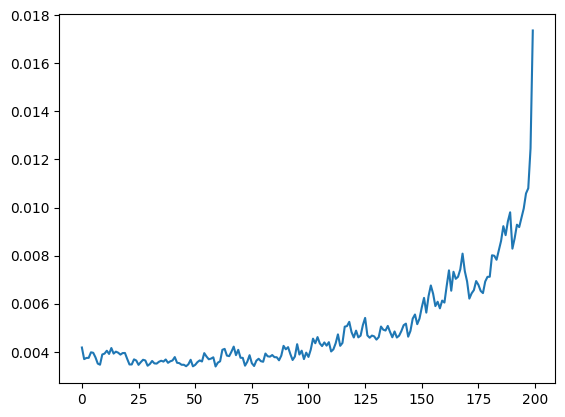

In [19]:
pd.Series(F.softmax(model.timesteps_attn.weights, 0).detach()).plot();

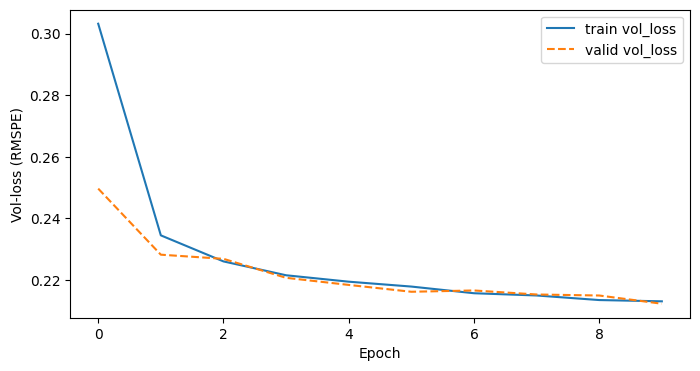

In [20]:
plt.figure(figsize=(8,4))
plt.plot(history.train_vol,    label='train vol_loss')
plt.plot(history.valid_vol, '--', label='valid vol_loss')
plt.xlabel('Epoch')
plt.ylabel('Vol‐loss (RMSPE)')
plt.legend()
plt.show()

In [21]:
!rm "/content/drive/MyDrive/Colab Notebooks/RBS DL 2025/PRO/train.npy"